In [1]:
from torch.optim import Adam
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch
import yaml
import pandas as pd
from time import time
import numpy as np
from src.utils import get_path_projeto

In [ ]:
# 1. Carregando os dados
dir_projeto = get_path_projeto()
path_csv = dir_projeto / "data/staged/dados_empilhados.csv"
config_csv = {"sep": "\t", "encoding": "utf-8"}

dataset = pd.read_csv(path_csv, **config_csv)

# 2. Selecionando apenas dados sobre a geração de energia eólica
wind_power_generation = dataset.loc[:, ["interval_start_local", "wind"]]
wind_power_generation.rename(
    columns={"interval_start_local": "date", "wind": "power_generation"}, inplace=True
)

# 3. Dados para treinar o modelo
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


lookback = 1
X, y = create_dataset(
    dataset=wind_power_generation["power_generation"].values, lookback=lookback
)


# 4. Criando a rede neural
class ArquiteturaRedeNeural(nn.Module):
    def __init__(self, lookback) -> None:
        super(ArquiteturaRedeNeural, self).__init__()
        self.lstm = nn.LSTM(
            input_size=lookback, hidden_size=50, num_layers=2, batch_first=True
        )
        self.linear = nn.Linear(in_features=50, out_features=lookback)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


# 5. Treinando o modelo
def rotina_treino(modelo, fn_perda, otimizador, data_loader, num_epochs):
    t0 = time()
    for epoch in range(num_epochs):
        modelo.train()
        for X_batch, y_batch in data_loader:
            y_pred = modelo(X_batch)
            loss = loss_fn(y_pred, y_batch)
            otimizador.zero_grad()
            loss.backward()
            otimizador.step()
        if (epoch + 1) % 10 != 0:
            continue
        modelo.eval()
        with torch.no_grad():
            y_pred = modelo(X)
            train_rmse = np.sqrt(loss_fn(y_pred, y))
        exec_time = time() - t0
        print(
            "Epoch %d: train RMSE %.4f, time %.4f s"
            % (epoch + 1, train_rmse, exec_time)
        )
        t0 = time()
    return modelo


rede_neural = ArquiteturaRedeNeural(lookback=lookback)
loss_fn = nn.MSELoss()
otimizador = Adam(params=rede_neural.parameters(), lr=0.05)
data_loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=10_000)

num_epochs = 2_000

rede_neural = rotina_treino(
    modelo=rede_neural,
    fn_perda=loss_fn,
    otimizador=otimizador,
    data_loader=data_loader,
    num_epochs=num_epochs,
)

/var/folders/g4/6w_d4rjs17n_cdn1lnl_nnf00000gn/T/ipykernel_35367/4034210821.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Epoch 10: train RMSE 2674.3618, time 258.6779 s


KeyboardInterrupt: 

# SUGESTÃO GPT

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from time import time
from src.utils import get_path_projeto

dir_projeto = get_path_projeto()

# 1. Set device
device = "cpu"# torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load data and prepare it as usual
dir_projeto = get_path_projeto()
path_csv = dir_projeto / "data/staged/dados_empilhados.csv"
config_csv = {"sep": "\t", "encoding": "utf-8"}
dataset = pd.read_csv(path_csv, **config_csv)
wind_power_generation = dataset.loc[:, ["interval_start_local", "wind"]]
wind_power_generation.rename(
    columns={"interval_start_local": "date", "wind": "power_generation"}, inplace=True
)


# 3. Modify the create_dataset function to use the device
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)

    # Convert lists to numpy arrays before creating tensors
    X = np.array(X)
    y = np.array(y)

    return (
        torch.tensor(X, dtype=torch.float32).unsqueeze(-1).to(device),
        torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device),
    )


lookback = 3
X, y = create_dataset(
    dataset=wind_power_generation["power_generation"].values, lookback=lookback
)


# 4. Update the model to use the device
class ArquiteturaRedeNeural(nn.Module):
    def __init__(self, lookback) -> None:
        super(ArquiteturaRedeNeural, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=500, num_layers=2, batch_first=True
        )
        self.linear = nn.Linear(in_features=500, out_features=1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


# Move model to the device
rede_neural = ArquiteturaRedeNeural(lookback=lookback).to(device)
loss_fn = nn.MSELoss()
otimizador = Adam(params=rede_neural.parameters(), lr=0.01)

# 5. Update the data loader
data_loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=100)


# 6. Train the model with the routine updated for the device
def rotina_treino(modelo, fn_perda, otimizador, data_loader, num_epochs):
    t0 = time()
    for epoch in range(num_epochs):
        modelo.train()
        for X_batch, y_batch in data_loader:
            # Move batches to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = modelo(X_batch)
            loss = fn_perda(y_pred, y_batch)

            # Backward pass and optimization
            otimizador.zero_grad()
            loss.backward()
            otimizador.step()

        # Evaluation step every 10 epochs
        if (epoch + 1) % 10 == 0:
            modelo.eval()
            with torch.no_grad():
                y_pred = modelo(X)
                train_rmse = np.sqrt(fn_perda(y_pred, y).item())
            exec_time = time() - t0
            print(
                f"Epoch {epoch + 1}: train RMSE {train_rmse:.4f}, time {exec_time:.4f} s"
            )
            t0 = time()
    # torch.cuda.empty_cache()
    return modelo


# Start training
num_epochs = 250#2_000
rede_neural = rotina_treino(
    modelo=rede_neural,
    fn_perda=loss_fn,
    otimizador=otimizador,
    data_loader=data_loader,
    num_epochs=num_epochs,
)

Using device: cpu
Epoch 10: train RMSE 1435.4869, time 319.4164 s
Epoch 20: train RMSE 1434.8075, time 345.2528 s


KeyboardInterrupt: 

In [11]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from time import time
from src.utils import get_path_projeto

dir_projeto = get_path_projeto()

# 1. Set device
device = "cpu"# torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load data and prepare it as usual
dir_projeto = get_path_projeto()
path_csv = dir_projeto / "data/staged/dados_empilhados.csv"
config_csv = {"sep": "\t", "encoding": "utf-8"}
dataset = pd.read_csv(path_csv, **config_csv)
wind_power_generation = dataset.loc[:, ["interval_start_local", "wind"]]
wind_power_generation.rename(
    columns={"interval_start_local": "date", "wind": "power_generation"}, inplace=True
)

scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(wind_power_generation[["power_generation"]])

# 3. Modify the create_dataset function to use the device
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)

    # Convert lists to numpy arrays before creating tensors
    X = np.array(X)
    y = np.array(y)

    return (
        torch.tensor(X, dtype=torch.float32).to(device),
        torch.tensor(y, dtype=torch.float32).to(device),
    )


lookback = 3
X, y = create_dataset(
    dataset=dados_normalizados, lookback=lookback
)

# 4. Update the model to use the device
class ArquiteturaRedeNeural(nn.Module):
    def __init__(self, lookback) -> None:
        super(ArquiteturaRedeNeural, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=500, num_layers=2, batch_first=True
        )
        self.linear = nn.Linear(in_features=500, out_features=1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Move model to the device
rede_neural = ArquiteturaRedeNeural(lookback=lookback).to(device)
loss_fn = nn.MSELoss()
otimizador = Adam(params=rede_neural.parameters(), lr=0.001)

# 5. Update the data loader
data_loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=10_000)


# 6. Train the model with the routine updated for the device
def rotina_treino(modelo, fn_perda, otimizador, data_loader, num_epochs):
    t0 = time()
    for epoch in range(num_epochs):
        modelo.train()
        for X_batch, y_batch in data_loader:
            # Move batches to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = modelo(X_batch)
            loss = fn_perda(y_pred, y_batch)

            # Backward pass and optimization
            otimizador.zero_grad()
            loss.backward()
            otimizador.step()

        # Evaluation step every 10 epochs
        if (epoch + 1) % 10 == 0:
            modelo.eval()
            with torch.no_grad():
                y_pred = modelo(X)
                train_rmse = np.sqrt(fn_perda(y_pred, y).item())
            exec_time = time() - t0
            print(
                f"Epoch {epoch + 1}: train RMSE {train_rmse:.10f}, time {exec_time:.4f} s"
            )
            t0 = time()
    # torch.cuda.empty_cache()
    return modelo


# Start training
num_epochs = 250#2_000
rede_neural = rotina_treino(
    modelo=rede_neural,
    fn_perda=loss_fn,
    otimizador=otimizador,
    data_loader=data_loader,
    num_epochs=num_epochs,
)

Epoch 10: train RMSE 0.0234149822, time 180.0183 s
Epoch 20: train RMSE 0.0091072156, time 177.2755 s
Epoch 30: train RMSE 0.0085480254, time 175.3257 s
Epoch 40: train RMSE 0.0080323879, time 175.6571 s
Epoch 50: train RMSE 0.0075696674, time 176.3173 s
Epoch 60: train RMSE 0.0071778592, time 176.8427 s
Epoch 70: train RMSE 0.0068761897, time 176.6236 s
Epoch 80: train RMSE 0.0066577730, time 176.7773 s
Epoch 90: train RMSE 0.0065759976, time 176.7905 s
Epoch 100: train RMSE 0.0063749044, time 176.8199 s
Epoch 110: train RMSE 0.0063510425, time 177.1614 s
Epoch 120: train RMSE 0.0062311515, time 176.4237 s
Epoch 130: train RMSE 0.0077334826, time 177.7432 s
Epoch 140: train RMSE 0.0061550001, time 208.7065 s
Epoch 150: train RMSE 0.0061304864, time 209.2378 s
Epoch 160: train RMSE 0.0063506828, time 184.6635 s
Epoch 170: train RMSE 0.0061176836, time 179.7697 s
Epoch 180: train RMSE 0.0060655426, time 188.9854 s
Epoch 190: train RMSE 0.0061433636, time 188.3563 s
Epoch 200: train RMSE

In [15]:
rede_neural.eval()
with torch.no_grad():
    y_pred = rede_neural(X)

In [37]:
y_pred_numpy = y_pred.to("cpu").numpy()

In [43]:
yyyy = scaler.inverse_transform(y_pred_numpy.reshape(1,-1))

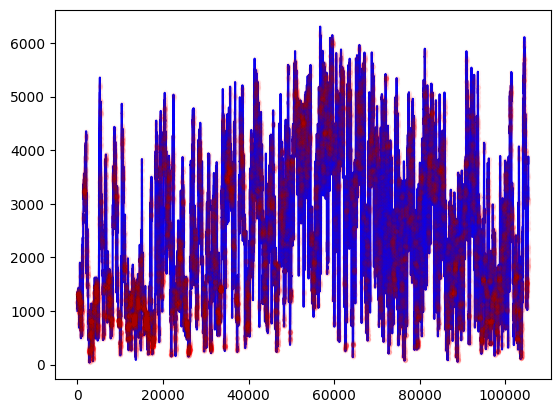

In [121]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(wind_power_generation[["power_generation"]].values, c="b")
plt.plot(yyyy.flatten(), c="r", marker=".", alpha=0.01)
plt.show()

In [21]:
proximos = []
rede_neural.eval()
for n in range(10_000):
    with torch.no_grad():
        if n == 0:
            proximos.append(rede_neural(X[-1]))
            continue
        proximos.append(rede_neural(proximos[-1]))
# proximos_ = scaler.inverse_transform(np.array(proximos).reshape(1, -1))

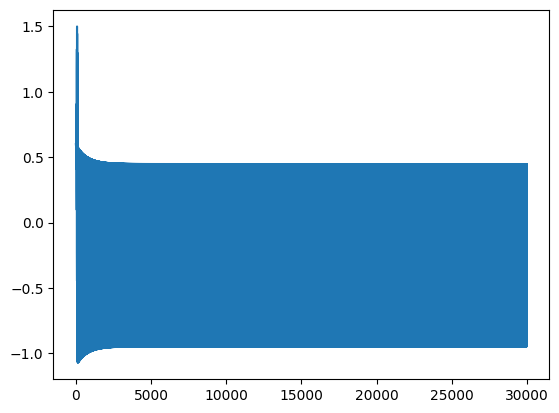

In [28]:
f_map = lambda tensor: tensor.to("cpu").numpy().flatten().tolist()
a = list(map(f_map,proximos))
from functools import reduce
f_reduce = lambda old, new: old + new
aa = reduce(f_reduce, a, [])
from matplotlib import pyplot as plt
plt.plot(aa)
plt.show()

In [20]:
with torch.no_grad():
    print(X[-1])
    print(rede_neural(X[-1]))

tensor([[0.6008],
        [0.5979],
        [0.5963]])
tensor([[0.6002],
        [0.5955],
        [0.5945]])


In [111]:
proximos_

array([[3787.8586, 3798.7197, 3809.583 , ..., 6525.2617, 6525.2617,
        6525.2617]], dtype=float32)

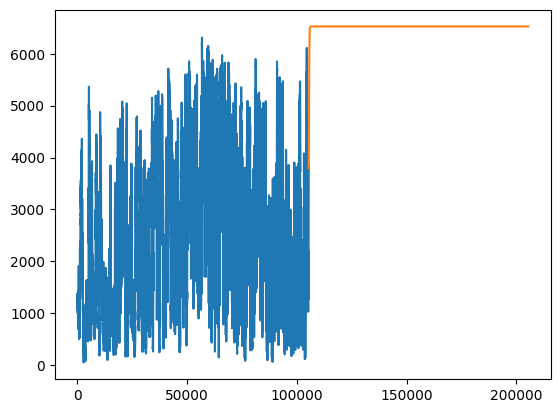

In [110]:
plt.plot(list(range(len(yyyy.flatten()))), yyyy.flatten())
plt.plot(list(range(len(yyyy.flatten()), len(yyyy.flatten()) + len(proximos_.flatten()))), proximos_.flatten())

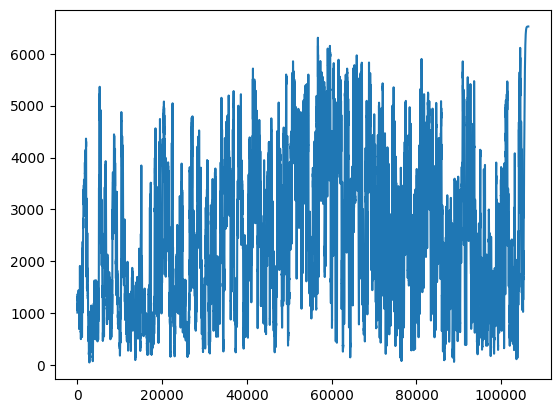

In [99]:
plt.plot(aaaa)
plt.show()

In [80]:
import numpy as np

torch.Tensor(np.array(1, dtype= np.float32).reshape(1,1)).to(device)

tensor([[1.]], device='cuda:0')

In [82]:
proximos

[0.59806204,
 0.59979564,
 0.6015296,
 0.60326385,
 0.6049984,
 0.6067332,
 0.60846823,
 0.61020344,
 0.61193883,
 0.61367434,
 0.61541,
 0.61714566,
 0.61888134,
 0.62061703,
 0.6223527,
 0.6240883,
 0.62582374,
 0.62755907,
 0.62929416,
 0.631029,
 0.6327636,
 0.63449794,
 0.6362319,
 0.63796556,
 0.6396988,
 0.64143157,
 0.6431639,
 0.6448957,
 0.64662695,
 0.6483576,
 0.65008765,
 0.65181696,
 0.6535456,
 0.6552735,
 0.6570006,
 0.65872693,
 0.66045237,
 0.66217685,
 0.6639004,
 0.66562295,
 0.66734445,
 0.6690649,
 0.67078424,
 0.6725024,
 0.6742194,
 0.67593515,
 0.6776497,
 0.6793629,
 0.68107474,
 0.68278515,
 0.68449414,
 0.68620163,
 0.6879076,
 0.6896119,
 0.6913147,
 0.6930158,
 0.69471526,
 0.6964129,
 0.6981088,
 0.6998028,
 0.70149493,
 0.70318514,
 0.70487344,
 0.7065598,
 0.70824397,
 0.70992607,
 0.71160614,
 0.713284,
 0.7149596,
 0.71663296,
 0.71830404,
 0.71997267,
 0.7216389,
 0.7233027,
 0.724964,
 0.7266228,
 0.728279,
 0.7299326,
 0.73158354,
 0.7332318,
 0.73

In [71]:
torch.Tensor([1], size=[1,1]).shape

TypeError: new() received an invalid combination of arguments - got (list, size=list), but expected one of:
 * (*, torch.device device = None)
      didn't match because some of the keywords were incorrect: size
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device = None)
 * (object data, *, torch.device device = None)


In [67]:
X[-1]

tensor([[0.5963]], device='cuda:0')

In [12]:
torch.cuda.empty_cache()